<img src='https://www.uhd.edu/academics/sciences/PublishingImages/Pages/ms-BS-DataScience/DataScience1-01.png' height="100px" width="850px" style="margin-left: auto;margin-right: 0">



# Projeto Final Data Science

Olá! Seja muitíssimo bem vindo à minha entrega final do projeto para a área de estudos de Data Science do Grupo Turing!!!  <br/>
Abaixo, um sumário do que você irá encontrar:

**Sumário**  
&nbsp; ✔ [Conceitos sobre Hockey no Gelo](#Antes..-alguns-conceitos-sobre-Hockey-no-Gelo)
1. [Setup](#1.-Setup)
2. [Web Scraping](#2.-Web-Scraping)
3. [Análise e Visualização de Dados](#3.-Análise-e-Visualização-de-Dados)
  - [Join dos DataSets](#Join-dos-DataSets)
  - [Limpeza dos dados](#Limpeza-dos-dados)
  - [Heatmap e correlação entre as variáveis](#Heatmap-e-correlação-entre-as-variáveis)
  - [Vitórias acumuladas ao longo do tempo](#Vitórias-acumuladas-ao-longo-do-tempo)
  - [Análise das demais variáveis + O que destaca o Detroit Red Wings dos demais times?](#Análise-das-demais-variáveis-+-O-que-destaca-o-Detroit-Red-Wings-dos-demais-times?)
  - [Gols Marcados x Vitórias](#Gols-Marcados-x-Vitórias)
  - [Gols tomados x Vitórias](#Gols-tomados-x-Vitórias)
  - [Penalidades](#Penalidades)
  - [Pupularidade: Fãs](#Pupularidade:-Fãs)
 
 
 

##  Antes.. alguns conceitos sobre Hockey no Gelo
&nbsp; ✔  É um esporte popular entre os países "frios", como EUA e Canada.  
&nbsp; ✔  Existe desde o século 18.  
&nbsp; ✔  Dimensões da quadra: 60m x 30m.  
&nbsp; ✔  Quem faz mais gols ganha.  
&nbsp; ✔  6 jogadores para cada time: 1 goleiro, 3 atacantes e 2 zagueiros.  
&nbsp; ✔  3 tempos de 20 minutos.  
&nbsp; ✔  Rolam várias brigas.  
&nbsp; ✔  Eu se jogasse hockey:

<img src='https://media2.giphy.com/media/d2S0hB0KSrQaONLchJ/giphy.gif?cid=ecf05e47jmuxdkuryu98syqg7p8mvxj1qrhoot59im00fxxa&rid=giphy.gif' height="100%" width="400" style="margin-left: auto;margin-right: auto">

## 1. Setup

Iremos importar as bibliotecas necessárias e definir o estilo para nossos gráficos. As versões usadas estão no arquivo `requirements.txt`.

In [1]:
# Importação/Limpeza/Manipulaçao de dados
import numpy as np
import pandas as pd

# Scrapping
from bs4 import BeautifulSoup
import requests

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import bar_chart_race as bcr

%matplotlib inline

plt.style.use('ggplot')

## 2. Web Scraping

Começaremos fazendo um exemplo de request para apenas a primeira página do site em questão. Vamos pegar o texto dessa resposta e atribuir à variável `source`:

In [2]:
source = requests.get('https://scrapethissite.com/pages/forms/?page_num=1').text

Em seguida, usaremos o BreautifulSoup para identificar a informação que queremos. Nesse caso, estamos indo atrás da tag `<table ...>`. Você pode retirar o comentário do print para visualizar o código HTML da página (cuidado, são muitas linhas).

In [3]:
soup = BeautifulSoup(source, 'lxml')
# print(soup.prettify)

In [4]:
table = soup.find_all('table')
# print(table)

O pandas possui uma função que lê html e transforma em dataframe. Faremos isso abaixo:

In [5]:
df_test = pd.read_html(str(table))[0]
df_test.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Boston Bruins,1990,44,24,NaN,0.550,299,264,35
1,Buffalo Sabres,1990,31,30,NaN,0.388,292,278,14
2,Calgary Flames,1990,46,26,NaN,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,NaN,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,NaN,0.425,273,298,-25


As linhas anteriores serviram apenas para a primeria página, mas e as 23 demais? Para as outras, criaremos uma função para fazer o scrapping de mais de uma página. Iremos apenas repetir os passos anteriores, mas iterando sobre as páginas.

In [6]:
def scrape_table(url, page_nums):
    df = []
    
    for i in range(1, page_nums + 1):
        source = requests.get(url[:-1] + str(i)).text
        soup = BeautifulSoup(source, 'lxml')
        table = soup.find_all('table')
        df.append(pd.read_html(str(table))[0])

    df = pd.concat(df, ignore_index = True)
    return df

In [7]:
df = scrape_table(url = 'https://scrapethissite.com/pages/forms/?page_num=1', page_nums = 24)

Farei um `df.tail()` como um sanity check

In [8]:
df.tail()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
577,Tampa Bay Lightning,2011,38,36,8.0,0.463,235,281,-46
578,Toronto Maple Leafs,2011,35,37,10.0,0.427,231,264,-33
579,Vancouver Canucks,2011,51,22,9.0,0.622,249,198,51
580,Washington Capitals,2011,42,32,8.0,0.512,222,230,-8
581,Winnipeg Jets,2011,37,35,10.0,0.451,225,246,-21


Parece estar tudo ok. Salvaremos o dataset no arquivo `data/hockey_teams.csv`.

In [9]:
df.to_csv("data/hockey_teams.csv",index = False)

## 3. Análise e Visualização de Dados

### Join dos DataSets


Com o scrapping pronto, vamos unir este dataset com o fornecido (`DataSet ESPN.csv`) para finalmente começarmos nossa análise de dados!!!

Irei farei um inner join das duas tabelas para reunir os dados em um único dataframe e facilitar a análise:

In [10]:
df1 = pd.read_csv('data/hockey_teams.csv')

In [11]:
df1.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Boston Bruins,1990,44,24,NaN,0.550,299,264,35
1,Buffalo Sabres,1990,31,30,NaN,0.388,292,278,14
2,Calgary Flames,1990,46,26,NaN,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,NaN,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,NaN,0.425,273,298,-25


In [12]:
df2 = pd.read_csv('data/DataSet ESPN.csv', index_col = 'Unnamed: 0')

In [13]:
# Para o join dar certo nas colunas que queremos, irei renomear a coluna "Team" para "Team Name" no df2
df2.columns = ['Team Name', 'Home Games', 'Home Total', 'Home Average', 'Road Games',
       'Road Average', 'Overall Games', 'Overall Average', 'Year',
       'Save Percentage', 'Penalty Minutes', 'Penalty Minutes Against']

In [14]:
df2.head()

,Team Name,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against
0,Montreal Canadiens,41,"824,308","20,105",41,"16,013",82,"18,059",2001,0.899,1020,1294
1,Detroit Red Wings,41,"819,795","19,995",41,"17,889",82,"18,942",2001,0.909,1082,1072
2,Philadelphia Flyers,41,"802,595","19,575",41,"17,182",82,"18,378",2001,0.903,1183,1332
3,St Louis Blues,41,"800,319","19,519",41,"16,898",82,"18,209",2001,0.899,1345,1366
4,Toronto Maple Leafs,41,"789,567","19,257",41,"17,172",82,"18,215",2001,0.908,1430,1243


Finalmente, o Inner join:

In [15]:
df = pd.merge(df1, df2, how = 'inner', on = ['Team Name', 'Year'])

Agora, podemos seguir com nossa análise em um único dataframe!

Vantagens desse join:
  - Facilita na hora de cruzar os dados dos times e suas vitórias/derrotas

Desvantagens:
  - Os anos de 2004 e 2005 ficam faltando, pois em df1 falta 2004 e df2 falta 2005. Além disso, perdemos as linhas de df1 que são do ano de 2000 para trás.

In [16]:
df.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Save Percentage,Penalty Minutes,Penalty Minutes Against
0,Mighty Ducks of Anaheim,2001,29,42,3.0,0.354,175,198,-23,41,"553,470","13,499",41,"16,645",82,"15,072",0.899,1136,1042
1,Boston Bruins,2001,43,24,9.0,0.524,236,201,35,41,"632,746","15,432",41,"16,462",82,"15,947",0.886,1325,1384
2,Buffalo Sabres,2001,35,35,1.0,0.427,213,200,13,41,"731,438","17,839",41,"16,168",82,"17,004",0.916,1249,1279
3,Calgary Flames,2001,32,35,3.0,0.390,201,220,-19,41,"681,535","16,622",41,"16,504",82,"16,563",0.894,1376,1564
4,Carolina Hurricanes,2001,35,26,5.0,0.427,217,217,0,41,"547,584","13,355",41,"15,575",82,"14,465",0.898,1083,1136


### Limpeza dos dados

A primeira coisa que farei, é um `df.info()`. Para ver as informações mais gerais do dataset.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 236
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Team Name                237 non-null    object 
 1   Year                     237 non-null    int64  
 2   Wins                     237 non-null    int64  
 3   Losses                   237 non-null    int64  
 4   OT Losses                237 non-null    float64
 5   Win %                    237 non-null    float64
 6   Goals For (GF)           237 non-null    int64  
 7   Goals Against (GA)       237 non-null    int64  
 8   + / -                    237 non-null    int64  
 9   Home Games               237 non-null    int64  
 10  Home Total               237 non-null    object 
 11  Home Average             237 non-null    object 
 12  Road Games               237 non-null    int64  
 13  Road Average             237 non-null    object 
 14  Overall Games            2

Repare que ao fazermos `df.info()` algumas colunas estão como object e deveriam ser inteiros (como a `'Home Total'`). Isso se deve porque o separador dos milhares usado nessas colunas é `,`. Devemos então substituir esses separadores e transformar em inteiros:

In [18]:
df['Home Total'] = df['Home Total'].str.replace(',','').astype('int')
df['Home Average'] = df['Home Average'].str.replace(',','').astype('int')
df['Road Average'] = df['Road Average'].str.replace(',','').astype('int')
df['Overall Average'] = df['Overall Average'].str.replace(',','').astype('int')

Com essa parte dos dados limpos, veremos se há algum dado faltante nesse período ou se há algum valor muito distoante. Lembre que com o join, nosso período agora é de 2001 até 2011.

In [19]:
df.isna().sum()

Team Name                  0
Year                       0
Wins                       0
Losses                     0
OT Losses                  0
Win %                      0
Goals For (GF)             0
Goals Against (GA)         0
+ / -                      0
Home Games                 0
Home Total                 0
Home Average               0
Road Games                 0
Road Average               0
Overall Games              0
Overall Average            0
Save Percentage            0
Penalty Minutes            0
Penalty Minutes Against    0
dtype: int64

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,237.0,2006.278481,3.420787,2001.000,2003.000,2007.000,2009.000,2011.000
Wins,237.0,39.392405,7.771773,20.000,34.000,41.000,45.000,54.000
Losses,237.0,31.088608,7.003976,15.000,26.000,30.000,35.000,48.000
OT Losses,237.0,7.915612,3.504423,0.000,5.000,8.000,10.000,18.000
Win %,237.0,0.480371,0.094828,0.244,0.415,0.500,0.549,0.659
Goals For (GF),237.0,227.240506,26.168885,164.000,210.000,226.000,246.000,318.000
Goals Against (GA),237.0,225.852321,27.534095,164.000,207.000,225.000,244.000,303.000
+ / -,237.0,1.388186,39.312540,-113.000,-27.000,6.000,29.000,85.000
Home Games,237.0,40.962025,0.231596,40.000,41.000,41.000,41.000,42.000
Home Total,237.0,696997.708861,89496.423737,453456.000,634381.000,698077.000,763830.000,912155.000


In [21]:
df.describe(include='object')

,Team Name
count,237
unique,27
top,Edmonton Oilers
freq,9


## Heatmap e correlação entre as variáveis

Faremos o plot do heatmap para ajudar em nossa análise ao longo do notebook. A princípio, podemos ver que as vitórias estão positivamente correlacionadas com o número de gols feitos, seguido da quantidade de torcedores (tanto Home quanto Road) e da quantidade de defesas do goleiro.

Deixarei de lado algumas análises mais triviais, como a correlação negativa entre Vitórias e Derrotas, por exemplo.

In [22]:
m_corr = df.corr()

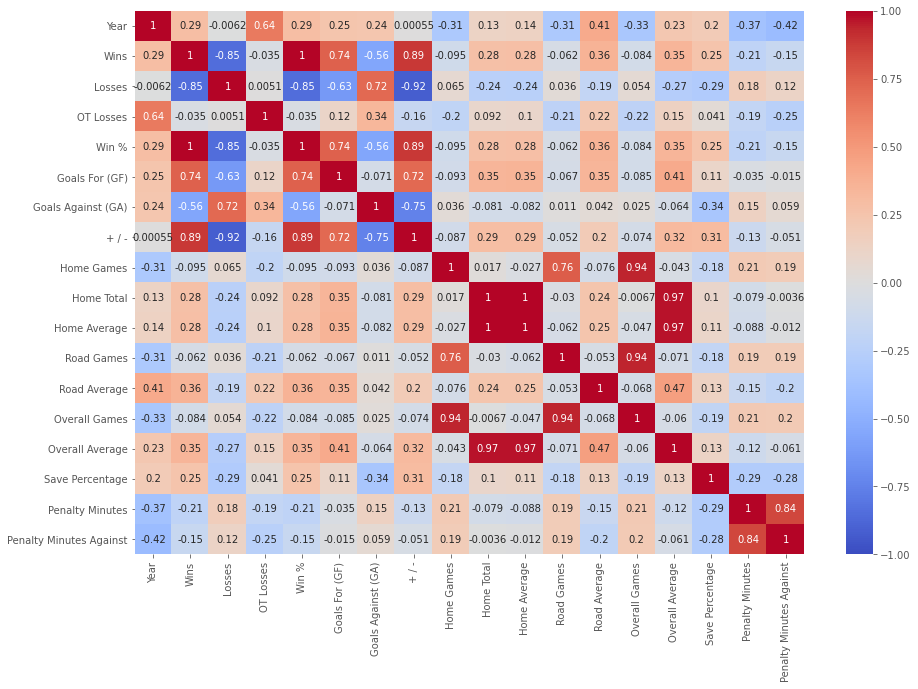

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(m_corr, vmin=-1, vmax=1, annot=True, cmap = 'coolwarm')
plt.show()

## Vitórias acumuladas ao longo do tempo

A primeira coisa que me veio a cabeça foi ver qual time acumulou mais vitórias ao longo do tempo. Para isso, fiz um bar chart race. Caso não consiga rodar a célula, o vídeo esta no arquivo `vitorias_acumuladas.mp4`.

In [24]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [25]:
# Deixando os dados no formato em que a biblioteca recomenda
df_race = pd.pivot_table(df, values='Wins', index=['Year'], columns=['Team Name'], aggfunc=np.sum)
df_race = df_race.cumsum()

In [26]:
# "Plotando" bar chart race
bcr.bar_chart_race(
    df=df_race,
    filename=None,
    orientation='h',
    sort='desc',
    n_bars=9,
    fixed_order=False,
    fixed_max=True,
    steps_per_period=100,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='%Y',
    period_summary_func=lambda v, r: {'x': .90, 'y': .23,
                                      's': f'Ano:',
                                      'ha': 'right', 'size': 11},
    period_length=2000,
    figsize=(5, 3),
    dpi=144,
    cmap='dark12',
    title='Vitórias acumuladas 2000 - 2011',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors = True) 

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
/home/diego/anaconda3/envs/gt-final-datascience/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/home/diego/anaconda3/envs/gt-final-datascience/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


De cara, vemos que o Detroid Red Wings foi o que mais acumulou vitórias desde 2001!

## Análise das demais variáveis + O que destaca o Detroit Red Wings dos demais times?

Seguiremos fazendo uma análise da relação entre as variáveis. Para fins de comparanção, iremos destacar os data points do Detroit Red Wings, para ver se ele se destaca.

### Gols Marcados x Vitórias

In [27]:
detroit_index = df[df['Team Name'] == 'Detroit Red Wings'].index

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


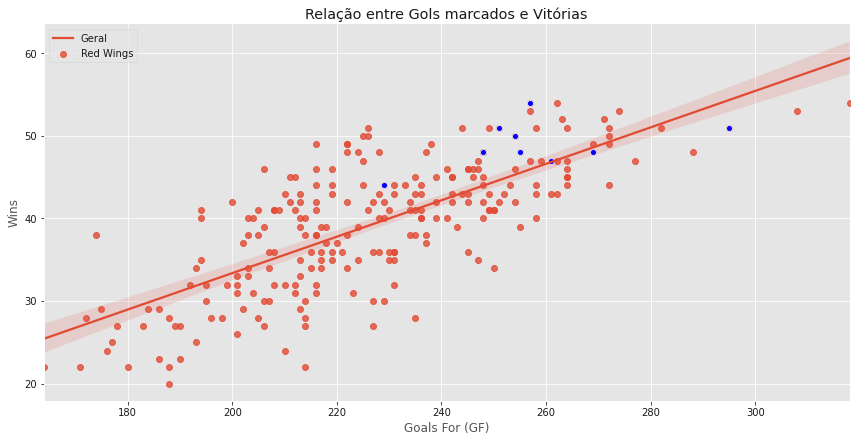

In [28]:
sns.lmplot(data = df, x = 'Goals For (GF)', y = 'Wins', height=6, aspect=2)
sns.scatterplot(data = df.iloc[detroit_index], x = 'Goals For (GF)', y = 'Wins', color = 'blue')

plt.title('Relação entre Gols marcados e Vitórias')
plt.legend(['Geral', 'Red Wings'])

plt.show()

No gráfico acima, claramente há uma relação positiva entre o número de gols marcados e o número de vitórias. OBS: Red Wings em azul.

### Gols tomados x Vitórias

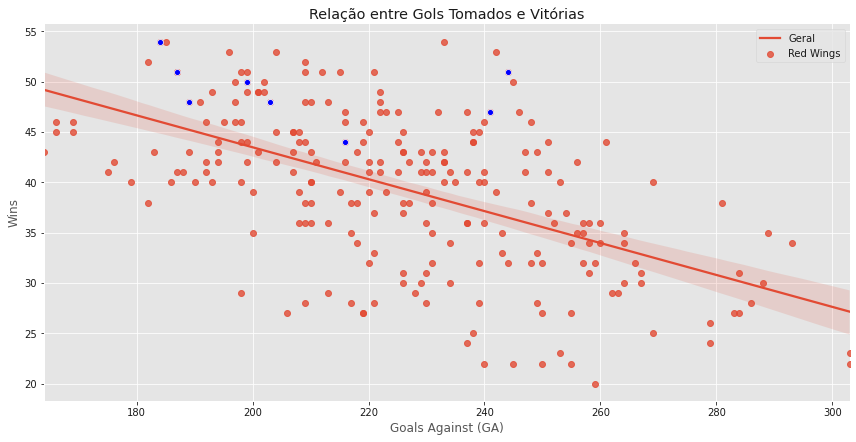

In [29]:
sns.lmplot(data = df, x = 'Goals Against (GA)', y = 'Wins', height=6, aspect=2)
sns.scatterplot(data = df.iloc[detroit_index], x = 'Goals Against (GA)', y = 'Wins', color = 'blue')

plt.title('Relação entre Gols Tomados e Vitórias')
plt.legend(['Geral', 'Red Wings'])

plt.show()

Há uma relação negativa entre os gols tomados e as vitórias. Note que nos dois exemplos, os red wings se posicionaram em regiões mais "favoráveis". Ou seja, aquelas nas quais eles marcavam mais gols, tomavam menos gols e ganhavam mais.

Na tabela abaixo, de fato conseguimos ver isso. Detroid possui a maior média de % de vitórias, juntamente com a maior média de gols feitos, e quase a menor média de gols tomados!

In [30]:
df.groupby('Team Name')[['Win %','Wins','Losses', 'Goals For (GF)', 'Goals Against (GA)']].mean().sort_values('Win %', ascending = False)

,Win %,Wins,Losses,Goals For (GF),Goals Against (GA)
Team Name,,,,,
Detroit Red Wings,0.597556,49.000000,21.777778,257.666667,207.333333
Vancouver Canucks,0.565222,46.333333,25.777778,246.333333,206.000000
San Jose Sharks,0.555444,45.555556,25.111111,239.777778,206.111111
New Jersey Devils,0.555444,45.555556,27.444444,213.777778,192.555556
Boston Bruins,0.519000,42.555556,27.444444,235.111111,214.444444
Ottawa Senators,0.512111,42.000000,29.444444,244.444444,223.666667
Dallas Stars,0.508111,41.666667,28.444444,225.222222,214.111111
Philadelphia Flyers,0.501333,41.111111,28.444444,239.888889,222.000000
Nashville Predators,0.493111,40.444444,30.666667,221.222222,217.333333


### Penalidades

Nunca assiti Hockey no gelo, mas em minhas pesquisas reparei que tem muitas tretas! O quanto será que isso impacta nas vitórias do time? Será que quanto mais porradaria, melhor o time performa?

Vamos medir isso a partir dos minutos de penalidade que o time levou e sofreu.

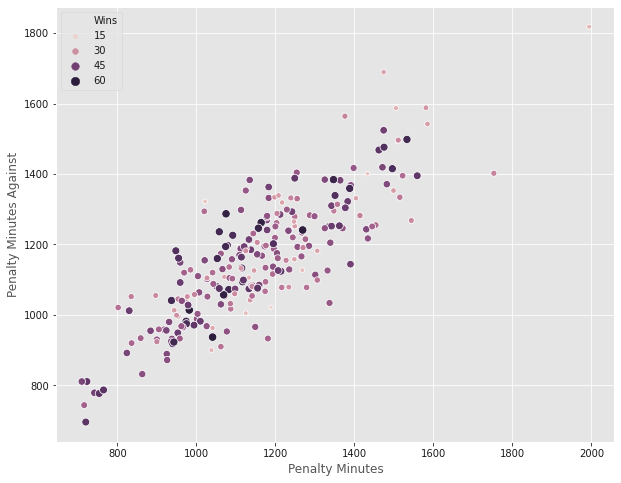

In [31]:
fig = plt.figure(figsize=(10,8))

sns.scatterplot(data = df, x = 'Penalty Minutes', y = 'Penalty Minutes Against', size = 'Wins', hue = 'Wins')

plt.show()

Não me parece haver uma relação muito clara entre as penalidades, sejam aquelas feitas pelo time ou recebidas, e o número de vitórias. A única relação é que quanto mais faltas recebidas, mais faltas tomadas são geradas (e vice versa). Indicando que violência gera violência.

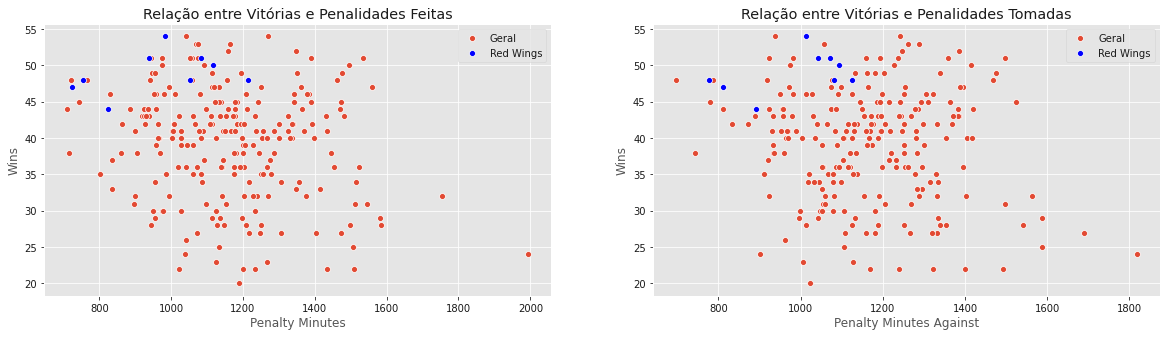

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))

sns.scatterplot(data = df, x = 'Penalty Minutes', y = 'Wins', ax = ax1)
sns.scatterplot(data = df.iloc[detroit_index], x = 'Penalty Minutes', y = 'Wins', ax = ax1, color = 'blue')
ax1.set_title('Relação entre Vitórias e Penalidades Feitas')

ax1.legend(['Geral', 'Red Wings'])

sns.scatterplot(data = df, x = 'Penalty Minutes Against', y = 'Wins', ax = ax2)
sns.scatterplot(data = df.iloc[detroit_index], x = 'Penalty Minutes Against', y = 'Wins', ax = ax2, color = 'blue')
ax2.set_title('Relação entre Vitórias e Penalidades Tomadas')

ax2.legend(['Geral', 'Red Wings'])

plt.show()

Novamente, não parece haver uma relação muito forte entre essas variáveis. Mas algo que se destaca, são os baixos valores das penalidades (tanto dadas quanto recebidas) para o time do Detroit Red Wings.

### Pupularidade: Fãs

Quero ver a evolução do **total** de torcedores por time a cada ano. Além de ver a evolução da popularidade desse esporte ao longo do ano, também quero ver quais times mais tiveram torcedores em seus jogos. Diferente da coluna`Home Total`, não temos um número de torcedores totais, ou seja, não há uma coluna `Overall Total`.

Para contornar isso, farei um pouco de feature engineering, multiplicando a coluna `Overall Average` pela coluna `Overall Games`, respeitando a fórmula da média.

$ \mu =  \frac{\sum_{i=1}^{n} X_i}{N}$

Como sanity check, farei esse cálculo nas colunas `Home Average`,`Home Total` e `Home Games` abaixo, e veja que os números batem!

In [33]:
df['Home Total'] / df['Home Games']

0      13499.268293
1      15432.829268
2      17839.951220
3      16622.804878
4      13355.707317
           ...     
232    17562.000000
233    17268.829268
234    19354.195122
235    18860.000000
236    18397.780488
Length: 237, dtype: float64

In [34]:
df['Home Average']

0      13499
1      15432
2      17839
3      16622
4      13355
       ...  
232    17562
233    17268
234    19354
235    18860
236    18397
Name: Home Average, Length: 237, dtype: int64

Prosseguirei com o feature engineering e a análise gráfica dessa coluna:

In [35]:
df['Overall Total'] = df['Overall Average'] * df['Overall Games']
df['Overall Total'].head()

0    1235904
1    1307654
2    1394328
3    1358166
4    1186130
Name: Overall Total, dtype: int64

Começaremos com uma análise do total de fãs desse esporte ao longo dos anos. Em seguida, vamos "quebrar" esse gráfico e ver qual parcela dos fãs torce para um time ou outro.

<AxesSubplot:xlabel='Year'>

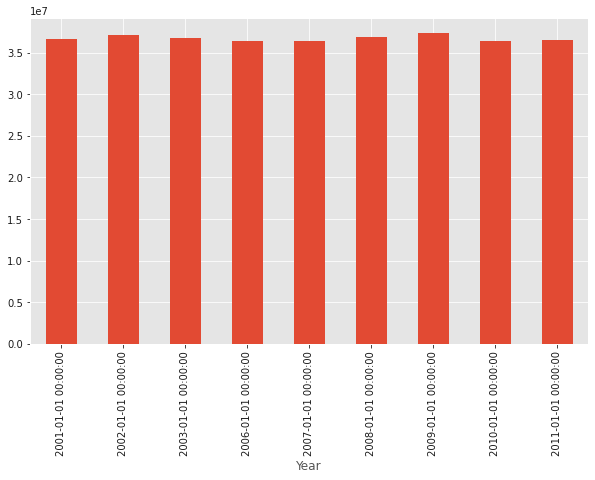

In [36]:
pd.pivot_table(df, values='Overall Total', index=['Year'], columns=['Team Name'], aggfunc=np.sum).sum(axis=1).plot(kind = 'bar', figsize = (10,6))

Vemos que o número de fãs desse esporte não teve alterações tão significativas entre 2000 e 2011, tivemos apenas mudanças marginais. Talvez isso está atrelado ao fato de ser um esporte antigo e, portanto, já ser bem popular/estabelecido nos países em que se pratica.

Agora, vamos ver quanto cada time representa desse total:

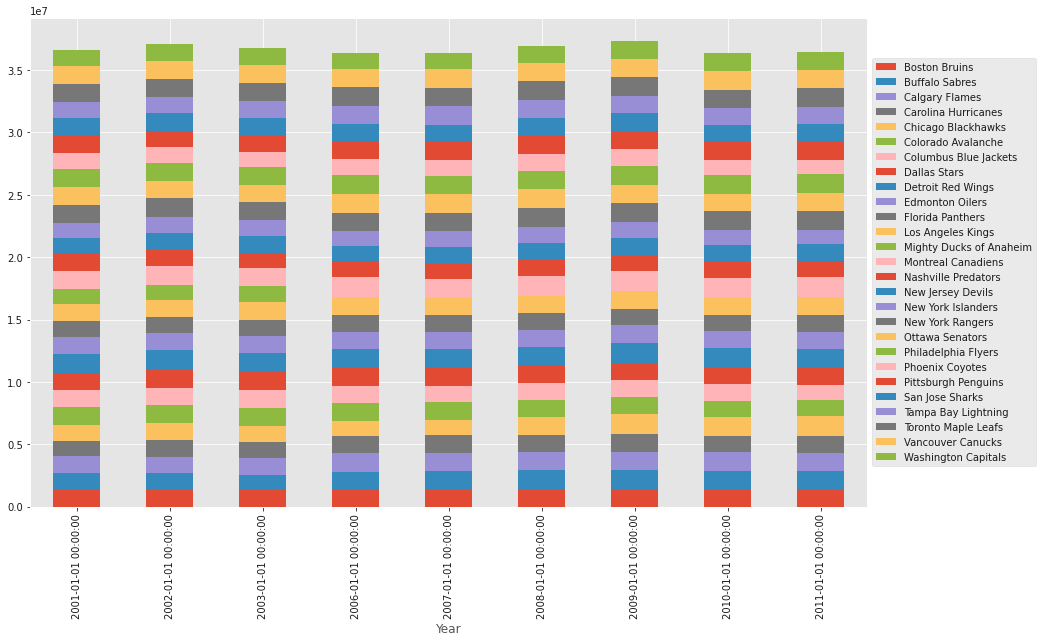

In [37]:
pd.pivot_table(df, values='Overall Total', index=['Year'], columns=['Team Name'], aggfunc=np.sum).plot(kind='bar', stacked=True, figsize = (15,9))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Repare que, apesar da enorme quantidade de informações no gráfico, podemos perceber que não há um time ou outro que concentra a quantidade de fãs. Em outras palavras, os fãs estão bem distribuídos.  
Será que existe alguma relação entre o número de fãs e a quantidade de vitórias?

In [38]:
df['Road Total'] = df['Road Average'] * df['Road Games']

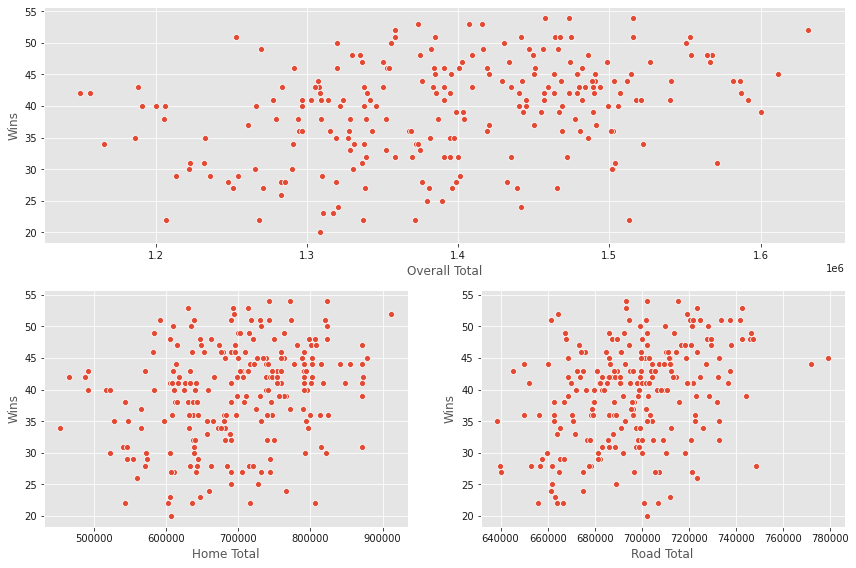

In [39]:
plt.figure(figsize = (30,20))

plt.subplot2grid((4,4), (0,0), colspan = 2)
sns.scatterplot(data = df, x = 'Overall Total', y = 'Wins')

plt.subplot2grid((4,4), (1,0))
sns.scatterplot(data = df, x = 'Home Total', y = 'Wins')

plt.subplot2grid((4,4), (1,1))
sns.scatterplot(data = df, x = 'Road Total', y = 'Wins')

plt.show()

Esses gráficos, juntamente com o coeficiente de correlação da matriz de correlação, nos mostram uma relação até que positiva entre essas variáveis. Entretanto, vale lembrar que **correlação não implica em causalidade**! Seria necessário isolar de uma maneira melhor essas variáveis e fazer testes estatísticos para estabelecer algum grau de causalidade. 